<a href="https://colab.research.google.com/github/MAClaassen/python_course/blob/main/2022_IDSP_MVS_III_Wk_5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Multivariate Statistics- Part III - Two-way ANOVA

## 0.0.0 Action Load Basic Libaries

In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import sklearn as skl
import scipy as sci
import scipy.io as sio


#configure the plotting defaluts
plt.rcParams['figure.figsize'] = [15.256 , 6.024]
plt.rcParams['figure.dpi'] = 300 

In [2]:
# new libaries for running annova tests

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

data_path='/content/drive/MyDrive/2022_SFC_IDSP/datasets/'


results_path='/content/drive/My Drive/2022_SFC_IDSP/Week_5/'

Mounted at /content/drive/


#### 0.0.3 Example load and inspect the data preparing for ANOVA

Throughout the later half of Lecture 5.2 we saved off modified versions of the fuel economy data, the summary table of interactions and all the Tukey test results.

Load those up know so we do not need to recalculate all them.


In [4]:
simple_mpg=pd.read_hdf(results_path+'idsp_wk5_simple_mpg_emissions_interactions')
simple_mpg.dtypes

year                 int64
make              category
model             category
VClass            category
trany             category
drive             category
eng_dscr          category
cylinders          float64
displ              float64
fuelType            object
city08               int64
UCity              float64
highway08            int64
UHighway           float64
co2TailpipeGpm     float64
interaction         object
dtype: object

In [5]:
interaction_groups=pd.read_hdf(results_path+'idsp_wk5_interaction_aggregate_mean_order')
interaction_groups.dtypes

interaction      object
count             int64
mean            float64
median          float64
standerd_dev    float64
skew            float64
dtype: object

In [6]:
tukey_results=pd.read_hdf(results_path+'idsp_wk5_tukey_results')
tukey_results.dtypes

group1       object
group2       object
meandiff    float64
p-adj       float64
lower       float64
upper       float64
reject         bool
dtype: object

## 3.0 Understadning the Interaction Terms

After running the two-way ANOVA we discovered that the interaction between 'fuel type' and 'drive train' were signifficant in explaining the variation of the means in the CO$_2$ emissions data.

The subsequent Tukey HSD test performed 1596 pairwise means tests, to reveal which means were statistically similar and which were statistically different.

We then showed that every interaction pair was similar to at least 6 other interactions, and some up to 50 interactions.

As noted in the lecture slides we do not an easy way to summarise these connections using connection circles, but this next bit of code should demonstrate similar insights and hint at other methods for thinking about the data.

#### 3.0.1 Example: Sort the interaction groups by their means and medians and visualise

This will allow us to remember what trends we saw in the ordering of the means.

In [7]:
means_order=(interaction_groups.sort_values('mean',ascending=True))
                                  
median_order =interaction_groups.sort_values('median',ascending=True)

                                  #

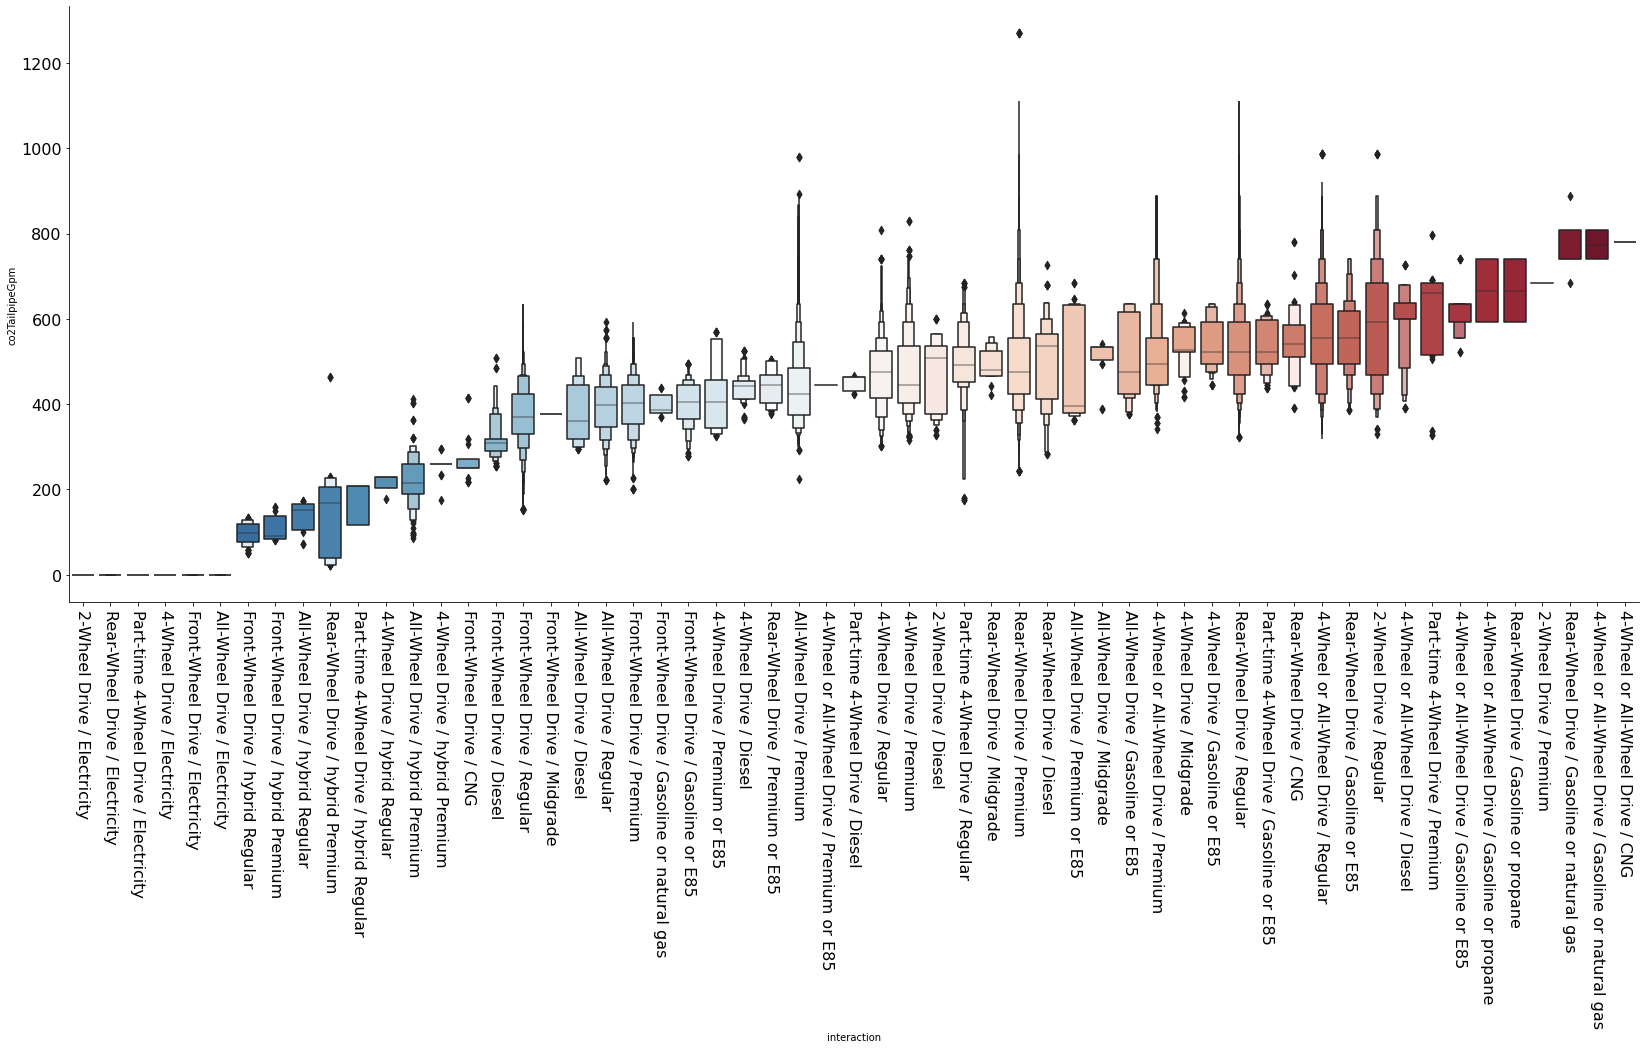

In [8]:
sns.catplot( data=simple_mpg,kind='boxen', x='interaction', y='co2TailpipeGpm',
            order=means_order['interaction'],
            palette='RdBu_r',
             height = 9, aspect=24/9)
plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)


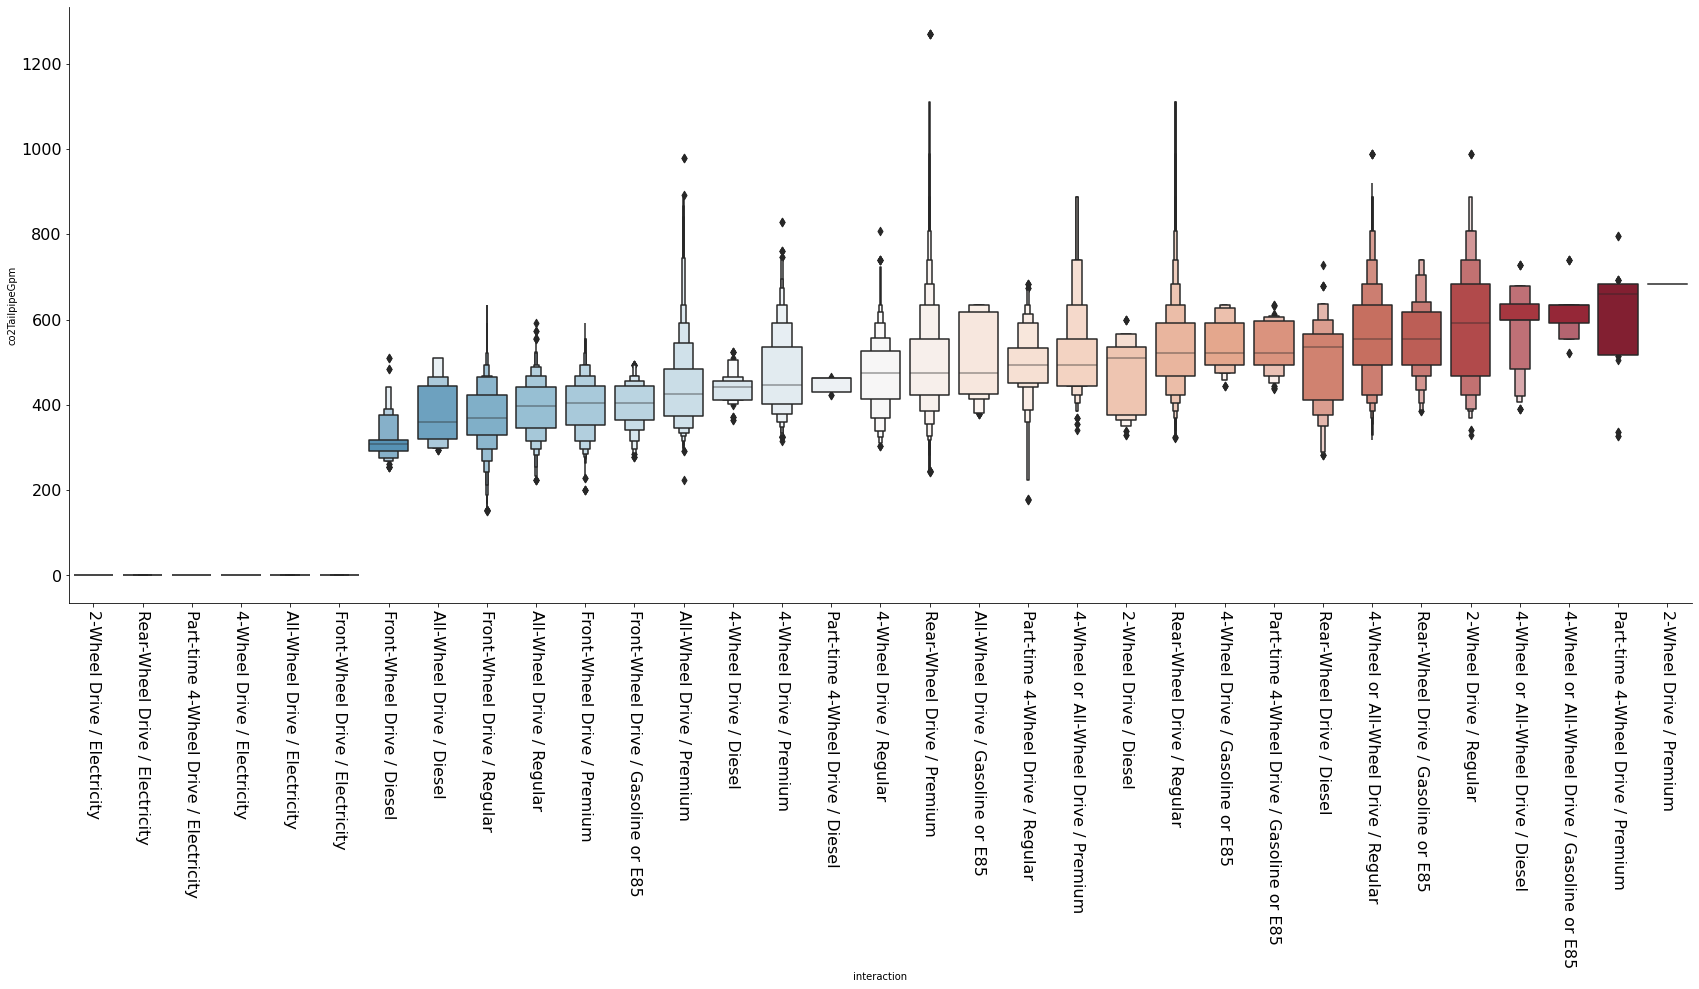

In [ ]:
sns.catplot( data=simple_mpg,kind='boxen', x='interaction', y='co2TailpipeGpm',
            order=median_order['interaction'],
            palette='RdBu_r',
             height = 9, aspect=24/9)
plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

### 3.1.2 Comments on the visualisation

the electric vechicles form a clear little group of similar means, and there apears to be stepwise structre to the data overall. This all seems in line with our bar chart from the end of 5.2. 

We are now going to have a play with building a data sturctre that connects groups of similar means and see if we can examine the overlaps.

In [10]:
tukey_results.head(5)

group1                       group2  meandiff  p-adj  \
0  2-Wheel Drive / Diesel  2-Wheel Drive / Electricity -474.6458  0.001   
1  2-Wheel Drive / Diesel      2-Wheel Drive / Premium  208.9696  0.900   
2  2-Wheel Drive / Diesel      2-Wheel Drive / Regular  105.8774  0.001   
3  2-Wheel Drive / Diesel       4-Wheel Drive / Diesel  -34.8987  0.900   
4  2-Wheel Drive / Diesel  4-Wheel Drive / Electricity -474.6458  0.001   

      lower     upper  reject  
0 -583.0972 -366.1944    True  
1 -164.8925  582.8317   False  
2   58.5178  153.2370    True  
3  -94.0533   24.2560   False  
4 -665.3792 -283.9124    True

### 3.2 Creating Groups of Similar Means

What we want to do is pull out all the results of the Tukey test where we have to accept the null hypothesis that the two means are the same. We then want to group these by all the 'group1' interaction names. These will form a **similarity group** (not a technical term, but the variable name that we will use).

#### 3.2.1 Example: Create the dataframe of all the similar means

In [11]:
tukey_accept_h0= tukey_results.loc[tukey_results.reject == False]

len(tukey_accept_h0)

502

In [ ]:
tukey_accept_h0.head(5)

group1                          group2  meandiff   p-adj  \
1  2-Wheel Drive / Diesel         2-Wheel Drive / Premium  208.9696  0.9000   
3  2-Wheel Drive / Diesel          4-Wheel Drive / Diesel  -34.8987  0.9000   
6  2-Wheel Drive / Diesel        4-Wheel Drive / Midgrade   56.0533  0.6364   
7  2-Wheel Drive / Diesel         4-Wheel Drive / Premium   -3.3194  0.9000   
8  2-Wheel Drive / Diesel  4-Wheel Drive / Premium or E85  -49.9876  0.8678   

      lower     upper  reject  
1 -164.8925  582.8317   False  
3  -94.0533   24.2560   False  
6  -19.0506  131.1572   False  
7  -48.7952   42.1563   False  
8 -125.0914   25.1163   False

#### 3.2.2 Example: Showing how to filter the Tukey results, to examine a particualr group

Here we look at all the interactions which are statistically similar to '2-Wheel Drive / Electricity'.

There are 11 elements here, including some which are hybrids so have some emissions in them. This again comes from how the difference of the means is calcualted. (see the lecture notes)

In [12]:
tukey_accept_h0.loc[tukey_accept_h0['group1']=='2-Wheel Drive / Electricity']

group1                                    group2  \
59   2-Wheel Drive / Electricity               4-Wheel Drive / Electricity   
66   2-Wheel Drive / Electricity            4-Wheel Drive / hybrid Regular   
76   2-Wheel Drive / Electricity             All-Wheel Drive / Electricity   
83   2-Wheel Drive / Electricity          All-Wheel Drive / hybrid Regular   
86   2-Wheel Drive / Electricity           Front-Wheel Drive / Electricity   
92   2-Wheel Drive / Electricity        Front-Wheel Drive / hybrid Premium   
93   2-Wheel Drive / Electricity        Front-Wheel Drive / hybrid Regular   
95   2-Wheel Drive / Electricity     Part-time 4-Wheel Drive / Electricity   
99   2-Wheel Drive / Electricity  Part-time 4-Wheel Drive / hybrid Regular   
102  2-Wheel Drive / Electricity            Rear-Wheel Drive / Electricity   

     meandiff   p-adj     lower     upper  reject  
59     0.0000  0.9000 -210.5031  210.5031   False  
66   212.3333  0.1871  -23.8864  448.5530   False  
76     0.0000  0.9000 -103.6446  103.6446   False  
83   135.7692  0.1010   -7.2395  278.7779   False  
86     0.0000  0.9000 -105.9509  105.9509   False  
92   107.3077  0.6249  -35.7010  250.3164   False  
93    96.2787  0.2431  -13.7531  206.3104   False  
95     0.0000  0.9000 -280.6708  280.6708   False  
99   172.2000  0.2067  -21.2390  365.6390   False  
102    0.0000  0.9000 -106.9186  106.9186   False

#### 3.2.3 Example: quickly see how many unique elements are in the first column

this will tell us how many unique groups there are (well a rough estimate anyway)

In [13]:
len(np.unique(tukey_accept_h0['group1']))

52

### 3.3 Gather groups of similar means

Coming out of the Tukey test we have two sets of information about the interaction of drive train and fuel type (drive-fuel). First, the Tukey results table filtered for simialr means tells us which drive-fuel combination is like another one (the dataframe 'tukey_accept_h0').  Second we have a dataframe providing the drive-fuel average for a specific combination of drive-fuel ('interaction_groups' dataframe). 

To see how the similar drive-fuel means are grouping, we need to assemble these two dataframes into a single dataframe that lets us examine the similarities.

To do this we want is to build a dataframe which looks like this:

|index|similarty\_group|group\_elements|CO2\_gpm_mean|similarity\_means|
|---|---|---|---|---|
|0|All-Wheel Drive / Electricity|All-Wheel Drive / Electricity|0\.0|0\.0|
|:|:|:|:|:|
|:|:|:|:|:|
|22|Part-time 4-Wheel Drive / hybrid Regular|4-Wheel Drive / Electricity|172\.2|79\.4613628587704|
|23|Rear-Wheel Drive / hybrid Premium|4-Wheel Drive / Electricity|150\.1860465116279|79\.4613628587704|
|24|All-Wheel Drive / hybrid Regular|4-Wheel Drive / Electricity|135\.76923076923077|79\.4613628587704|
|25|Front-Wheel Drive / hybrid Premium|4-Wheel Drive / Electricity|107\.3076923076923|79\.4613628587704|
|:|:|:|:|:|
|:|:|:|:|:|


#### 3.3.1 Example: Extract all the groups of similar means

First, need to get all the groups of similar means. (first cell)

Second, the next cells show that the list of lists that we have constructred is of all different lengths (should be expected as we know that some classes of vechicle are more popular than others).

In [14]:
tukey_groups = tukey_accept_h0.groupby(by='group1')['group2']


similarity_groups=[]
for group in tukey_groups.groups:
  similarity_groups.append(list(tukey_groups.get_group(group)))

In [15]:
similarity_groups[0]

['2-Wheel Drive / Premium',
 '4-Wheel Drive / Diesel',
 '4-Wheel Drive / Midgrade',
 '4-Wheel Drive / Premium',
 '4-Wheel Drive / Premium or E85',
 '4-Wheel Drive / Regular',
 '4-Wheel or All-Wheel Drive / Premium or E85',
 'All-Wheel Drive / Gasoline or E85',
 'All-Wheel Drive / Midgrade',
 'All-Wheel Drive / Premium',
 'All-Wheel Drive / Premium or E85',
 'Front-Wheel Drive / Gasoline or natural gas',
 'Front-Wheel Drive / Midgrade',
 'Part-time 4-Wheel Drive / Diesel',
 'Part-time 4-Wheel Drive / Regular',
 'Rear-Wheel Drive / Diesel',
 'Rear-Wheel Drive / Midgrade',
 'Rear-Wheel Drive / Premium',
 'Rear-Wheel Drive / Premium or E85']

In [16]:
len(similarity_groups[0])


19

In [17]:
similarity_groups[5]

['4-Wheel Drive / hybrid Regular',
 'All-Wheel Drive / Electricity',
 'All-Wheel Drive / hybrid Regular',
 'Front-Wheel Drive / Electricity',
 'Front-Wheel Drive / hybrid Premium',
 'Front-Wheel Drive / hybrid Regular',
 'Part-time 4-Wheel Drive / Electricity',
 'Part-time 4-Wheel Drive / hybrid Regular',
 'Rear-Wheel Drive / Electricity',
 'Rear-Wheel Drive / hybrid Premium']

In [18]:
len(similarity_groups[5])

10

#### 3.3.2 Example: Turning list of lists in a dataframe and combining with another dataframe

The key bit of our next little project is in the big loop below.  This seems like a really large loop, but if you read it slowly you will see the actions. Here is an outline of the steps

0.  create an empty list to place all the pairwise groups into.
1.  To each of the similarity groups we append on the drive-fuel combination that it was being compared to.
2.  Turn each list into a dataframe.(_df)$^1$
3.  Add a column to the dataframe which is filled with the name of the 'group' formed by comparison group ('group1' from Tukey results)
4.  add another column to _df which is filled with each elements mean value.

*   in order to insure that we match up the correct interaction with group element need to bring the interaction column with the mean values
*   we then use the merge function to match like with like

5.  Sort all the group values so they are in ascending order, and round the values to 2 decimal places.
6.  add another column with the groups average value (alternativly, could be be the value of the group center)
7.  append each iterations results into a list of dataframes. Key is that now each group has been structred into a form that they can be combined.
8.  useing concatanate transform the list of dataframes (one for each similarity group) into a single dataframe with the same columns.
9.  rename the 'means' column using a column name that conveys a sense of what is being measured.
10. finally, sort the columns so that the means of the similarity groups are ordered smallest emissions to largest.


---
$^1$ in this loop you will see several variables like ```_df``` where the  ```_``` on a right hand side of a variable neame is used to denote a 'dummy' variable, or a data object which will be overwritten repeatidly, but we need to provide a name, so we can have a more compact code. 


In [20]:
#step 0
dfs=[]
for i,group in enumerate(tukey_groups.groups,0):
  #step 1
  similarity_groups[i].append(group)
  #step 2
  _df=pd.DataFrame(similarity_groups[i], columns=['group_elements'])
  _df["group_elements"] = similarity_groups[i]
  #step 3
  _df["similarty_group"] = _df.tail(1)['group_elements'].values[0]
  #step 4
  _means= interaction_groups[interaction_groups['interaction'].isin(np.unique((_df.group_elements.values)))][['interaction','mean']]
  _df= _df.merge(_means, how="inner", left_on="group_elements", right_on="interaction")
  #step 5
  _df=_df.sort_values('mean',ascending=True)
  _df['mean']=_df['mean'].round(2)
  #step 6
  _df['similarity_means']= _df['mean'].mean()
  _df['similarity_means']=_df['similarity_means'].round(2)
  #step 7
  dfs.append(_df)

#step 8
similarity_groups_df=pd.concat(dfs,ignore_index=True)
#step 9
similarity_groups_df.rename(columns={'mean':'CO2_gpm_mean'},inplace=True)
#step 10
similarity_groups_df.sort_values('similarity_means',ascending=True, inplace=True,ignore_index=True)

similarity_groups_df

group_elements  \
0                  All-Wheel Drive / Electricity   
1                Front-Wheel Drive / Electricity   
2                 Rear-Wheel Drive / Electricity   
3          Part-time 4-Wheel Drive / Electricity   
4          Part-time 4-Wheel Drive / Electricity   
..                                           ...   
549            Part-time 4-Wheel Drive / Premium   
550  4-Wheel or All-Wheel Drive / Premium or E85   
551       Rear-Wheel Drive / Gasoline or propane   
552   Rear-Wheel Drive / Gasoline or natural gas   
553       Rear-Wheel Drive / Gasoline or propane   

                                       similarty_group  \
0                        All-Wheel Drive / Electricity   
1                        All-Wheel Drive / Electricity   
2                        All-Wheel Drive / Electricity   
3                        All-Wheel Drive / Electricity   
4                      Front-Wheel Drive / Electricity   
..                                                 ...   
549  4-Wheel or All-Wheel Drive / Gasoline or natur...   
550  4-Wheel or All-Wheel Drive / Gasoline or natur...   
551  4-Wheel or All-Wheel Drive / Gasoline or natur...   
552         Rear-Wheel Drive / Gasoline or natural gas   
553         Rear-Wheel Drive / Gasoline or natural gas   

                                     interaction  CO2_gpm_mean  \
0                  All-Wheel Drive / Electricity          0.00   
1                Front-Wheel Drive / Electricity          0.00   
2                 Rear-Wheel Drive / Electricity          0.00   
3          Part-time 4-Wheel Drive / Electricity          0.00   
4          Part-time 4-Wheel Drive / Electricity          0.00   
..                                           ...           ...   
549            Part-time 4-Wheel Drive / Premium        599.71   
550  4-Wheel or All-Wheel Drive / Premium or E85        444.35   
551       Rear-Wheel Drive / Gasoline or propane        666.53   
552   Rear-Wheel Drive / Gasoline or natural gas        765.67   
553       Rear-Wheel Drive / Gasoline or propane        666.53   

     similarity_means  
0                0.00  
1                0.00  
2                0.00  
3                0.00  
4               26.83  
..                ...  
549            652.84  
550            652.84  
551            652.84  
552            716.10  
553            716.10  

[554 rows x 5 columns]

#### 3.3.3 Example: here we reorder the columns to reflect some of the hierarchy in the data.

we also drop the 'interaction' column here as it is a bit redundant.

In [21]:
similarity_groups_df.drop(columns=['interaction'], inplace=True)#

similarity_groups_df=similarity_groups_df[['similarty_group','group_elements','CO2_gpm_mean','similarity_means']]
similarity_groups_df.head(4)

similarty_group                         group_elements  \
0  All-Wheel Drive / Electricity          All-Wheel Drive / Electricity   
1  All-Wheel Drive / Electricity        Front-Wheel Drive / Electricity   
2  All-Wheel Drive / Electricity         Rear-Wheel Drive / Electricity   
3  All-Wheel Drive / Electricity  Part-time 4-Wheel Drive / Electricity   

   CO2_gpm_mean  similarity_means  
0           0.0               0.0  
1           0.0               0.0  
2           0.0               0.0  
3           0.0               0.0

In [22]:
similarity_groups_df.loc[similarity_groups_df['similarty_group']=='2-Wheel Drive / Electricity']	

similarty_group                            group_elements  \
8   2-Wheel Drive / Electricity            4-Wheel Drive / hybrid Regular   
9   2-Wheel Drive / Electricity             All-Wheel Drive / Electricity   
10  2-Wheel Drive / Electricity           Front-Wheel Drive / Electricity   
11  2-Wheel Drive / Electricity            Rear-Wheel Drive / Electricity   
12  2-Wheel Drive / Electricity               2-Wheel Drive / Electricity   
13  2-Wheel Drive / Electricity        Front-Wheel Drive / hybrid Regular   
14  2-Wheel Drive / Electricity        Front-Wheel Drive / hybrid Premium   
15  2-Wheel Drive / Electricity          All-Wheel Drive / hybrid Regular   
16  2-Wheel Drive / Electricity  Part-time 4-Wheel Drive / hybrid Regular   
17  2-Wheel Drive / Electricity     Part-time 4-Wheel Drive / Electricity   
18  2-Wheel Drive / Electricity               4-Wheel Drive / Electricity   

    CO2_gpm_mean  similarity_means  
8         212.33             65.81  
9           0.00             65.81  
10          0.00             65.81  
11          0.00             65.81  
12          0.00             65.81  
13         96.28             65.81  
14        107.31             65.81  
15        135.77             65.81  
16        172.20             65.81  
17          0.00             65.81  
18          0.00             65.81

### 3.4 exploring the data frame through visualisations.

While we have a nice data table now which summarises up the findings of the Tukey analysis, all this work is being done so that we can try to visualise the connections that are in the data as hinted at by the tukey results.

These visualisations below are some best effoerts, but hint at some later ideas that we will approach from a macine learning perspective.

I am showing these as how one works through the process of trying to share and explain features in their analysis.

#### 3.4.1 Example: Inital visualisation of the resulting similarty groups using a 'strip plot' and a 'swarmplot'

Both of these plots show each member of a similarity and we have colored them by the geoup elements drive-fuel combination. While the colors work to show how the same element is represented in each similarity group, it is hard to understand that these are connected.

**swarm plots** are a catagroical scatter plot, where the points in the plot as distributed so that they assume the shape of the data distribution. kind of a combination of a violin plot and scatter plot



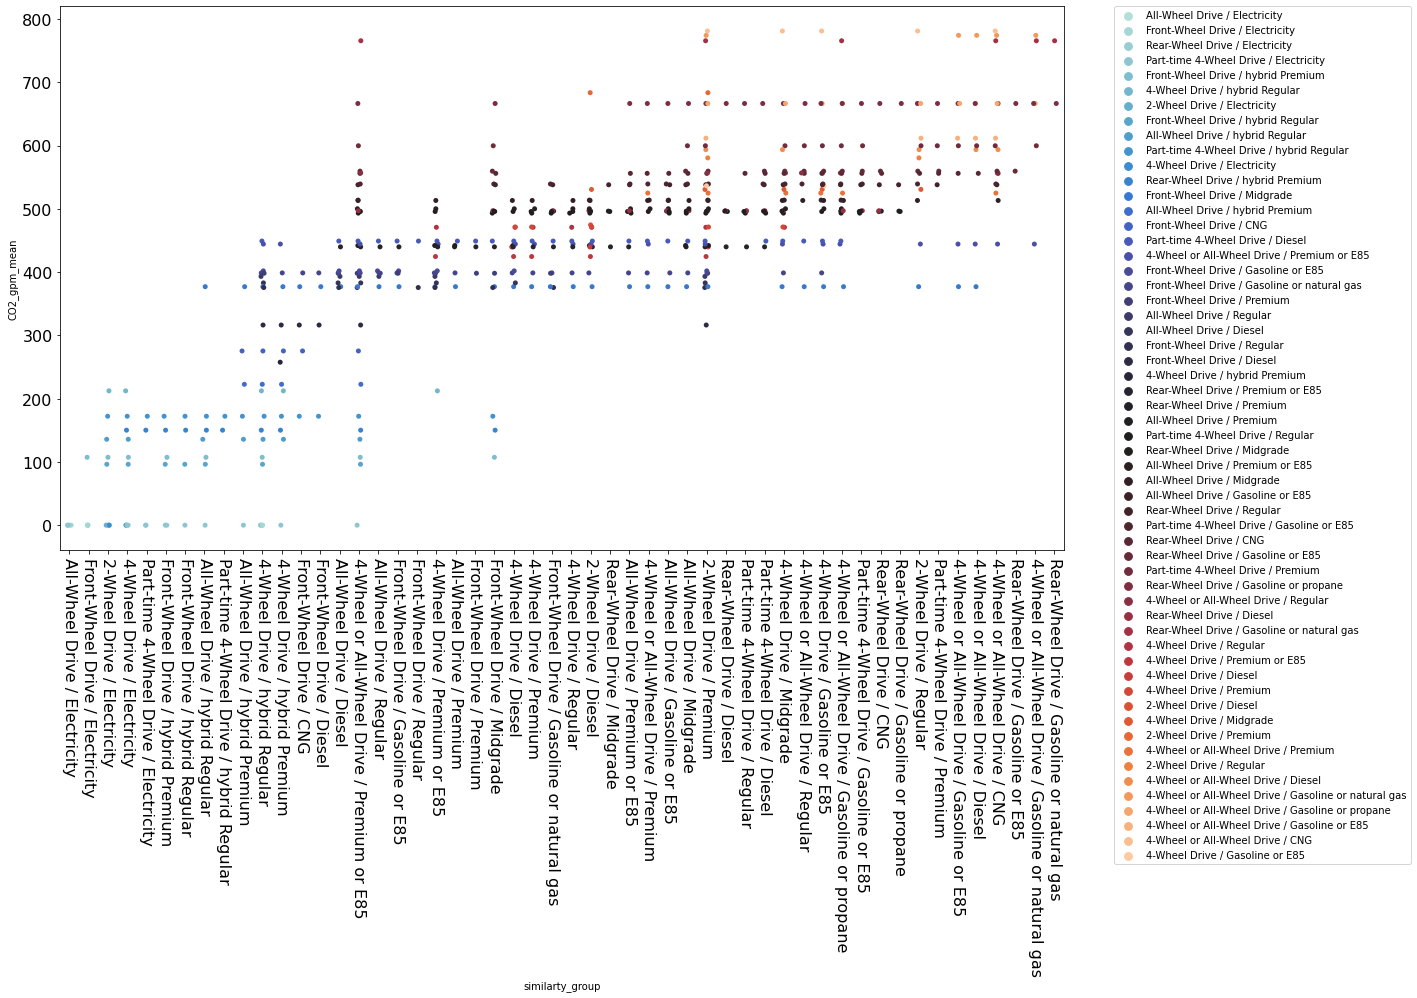

In [23]:
plt.figure(figsize=(18,10))
sns.stripplot(data=similarity_groups_df, x='similarty_group', y='CO2_gpm_mean', hue='group_elements',
              palette='icefire', jitter=True)

#note control of the legend to force it outside the bounding box of the data region.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)



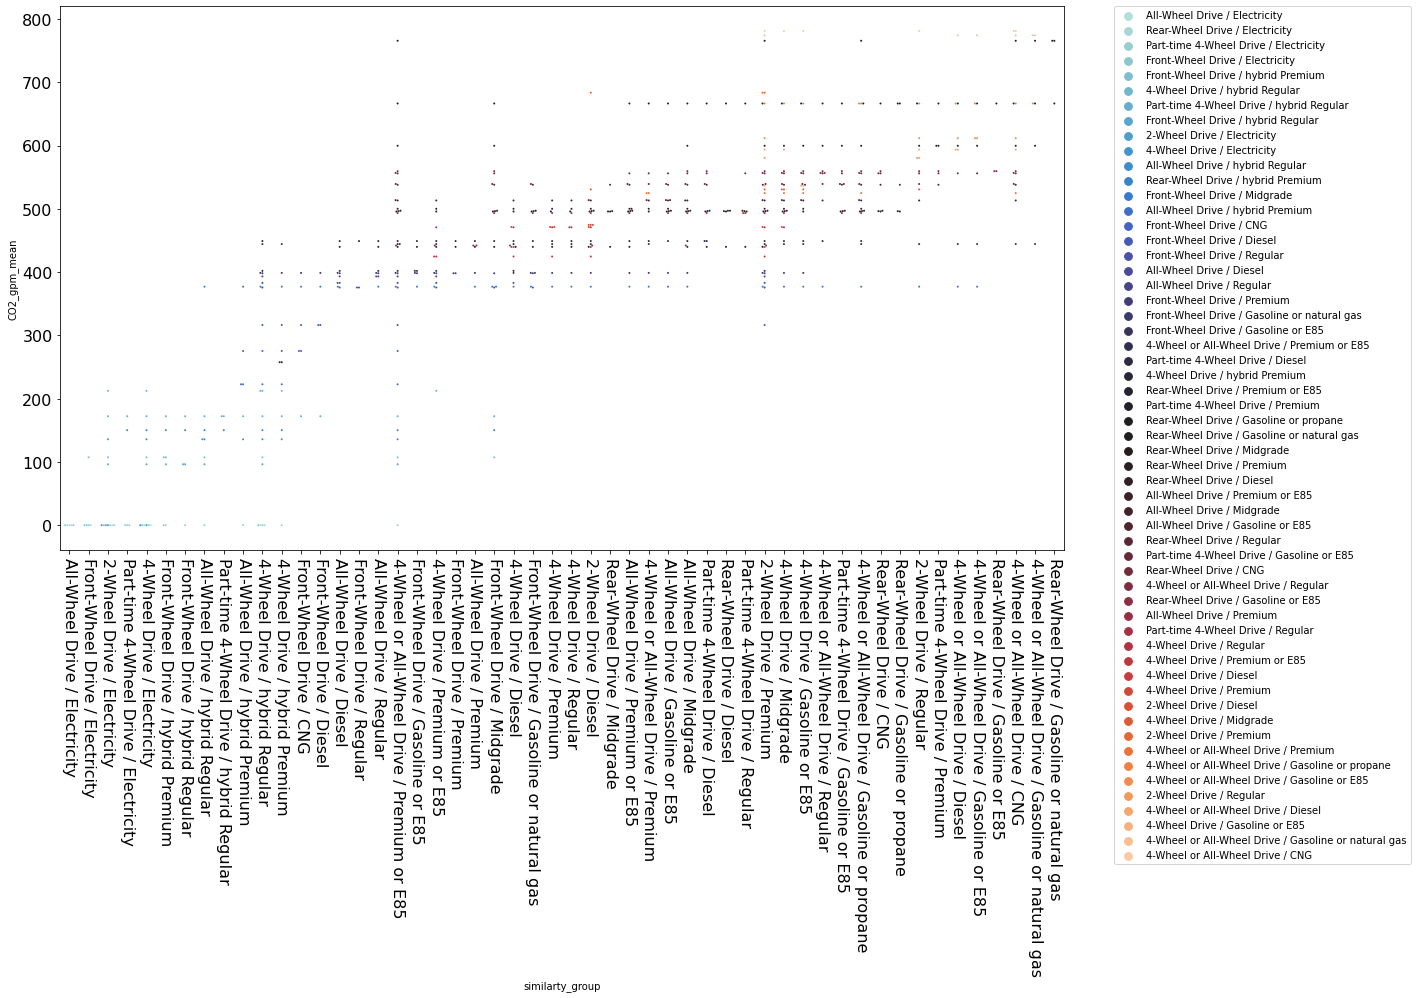

In [ ]:
plt.figure(figsize=(18,10))
sns.swarmplot(data=similarity_groups_df, x='similarty_group', y='CO2_gpm_mean', hue='group_elements',
              palette='icefire', s=2)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

#### 3.4.2 Example: Line plots

The Seaborn line plot allows connection of data points using the 'hue' keyword. this way we see the connections across the simialrity groups connecting the same drive-fuel combination that appears in multiple similartiy groups.

This polt however, makes the silimarity group membership a little opaque.

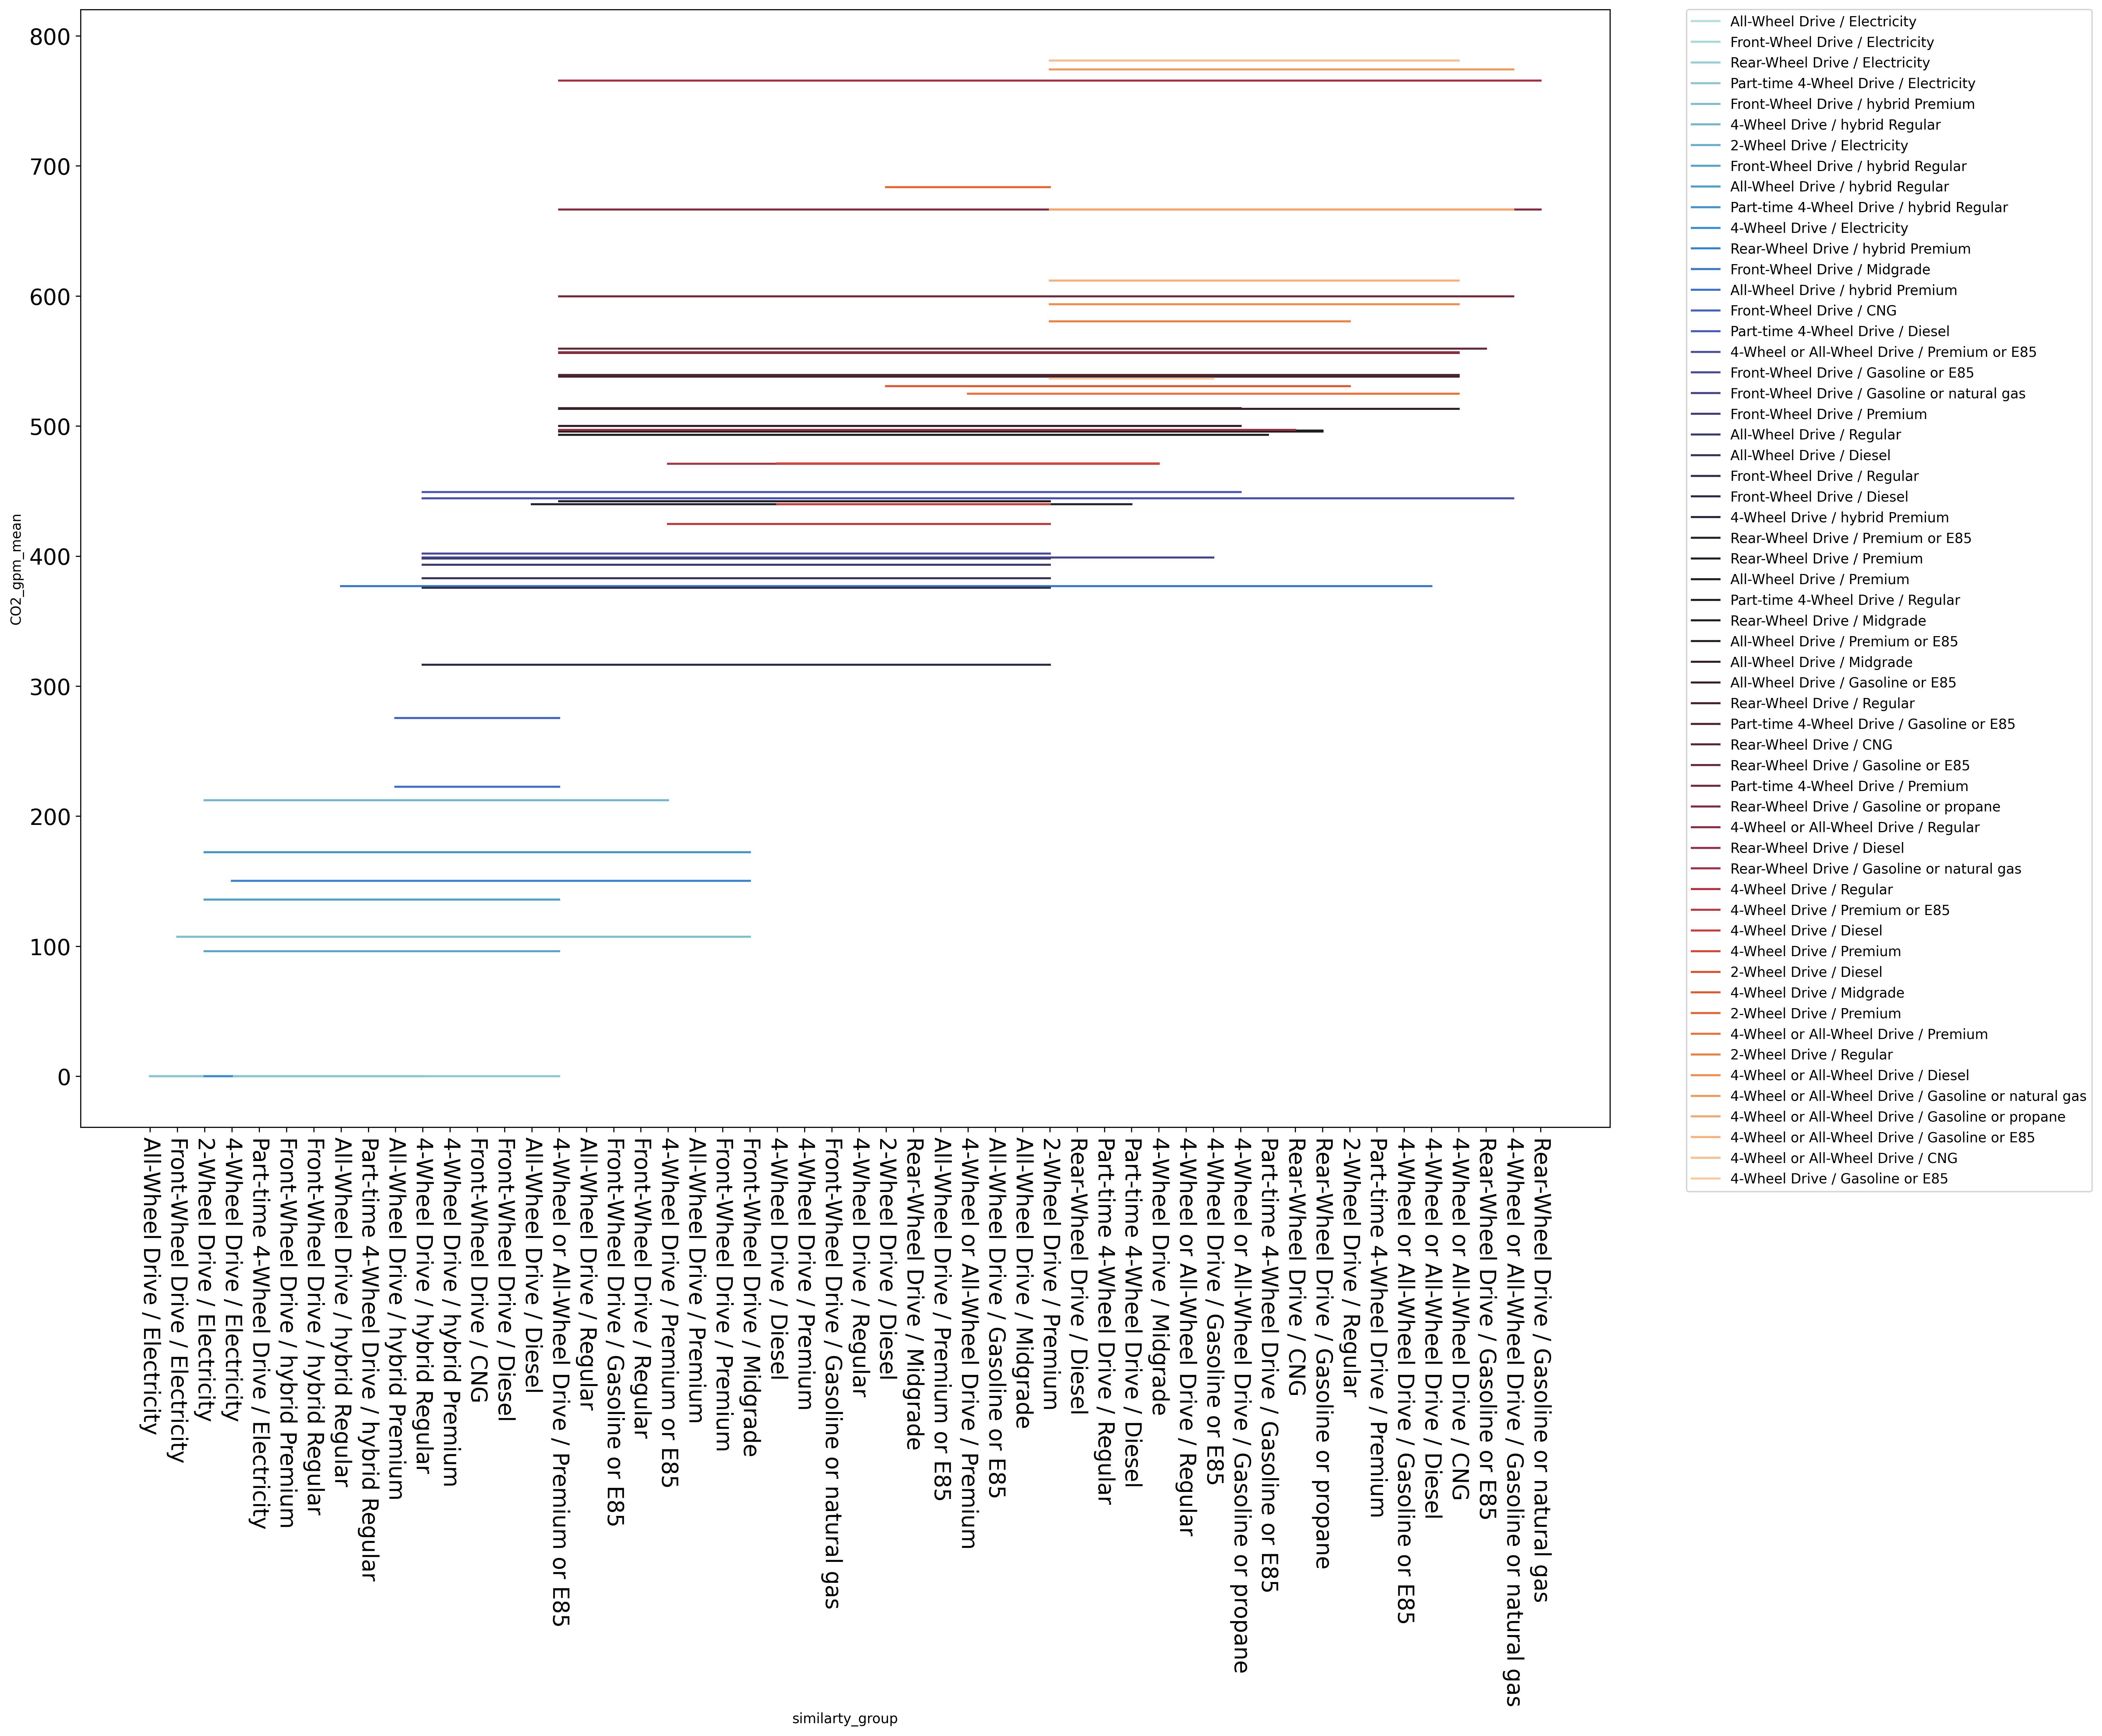

In [ ]:
plt.figure(figsize=(20,15))

sns.lineplot( data=similarity_groups_df, x='similarty_group', y='CO2_gpm_mean', hue='group_elements', palette='icefire')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

#### 3.4.3 Example of stacking multiple plots

Here we stack multiple plots and use two differnt color **palette** (seaborn term for a colormap).

Points are the members of a similarity group colored by their group mean.
Lines show connection between groups for elements that appear in multiple groups.

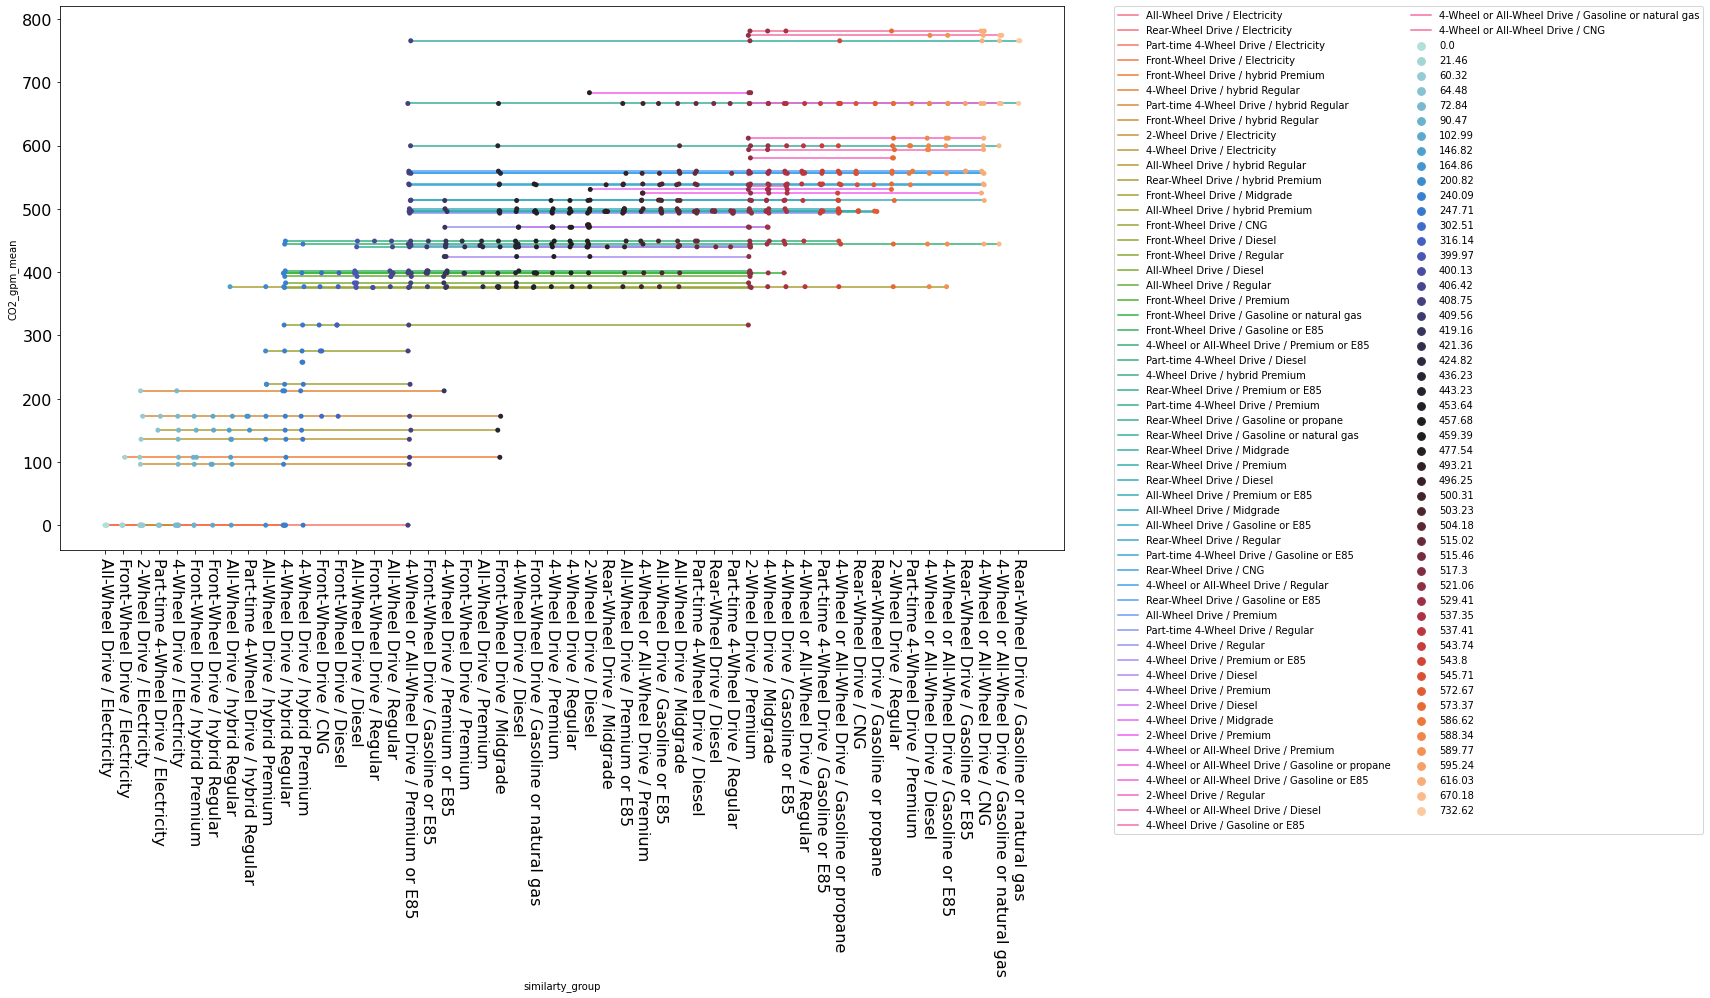

In [ ]:
plt.figure(figsize=(18,10))
sns.stripplot(data=similarity_groups_df, x='similarty_group', y='CO2_gpm_mean', hue='similarity_means', palette='icefire', jitter=True)
sns.lineplot( data=similarity_groups_df, x='similarty_group', y='CO2_gpm_mean', hue='group_elements')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=2)

plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

#plt.savefig(results_path +'Similarity_groups_rev_02')

3.4. Example: Inverting the point and lines

Here all the group elements are the x-axis and then they are conncted by their similarity groups.

While not a 'proper' connectivity plot this hints at how the similarity groups have overlapping memebership.

Maybe not the prittiest, but let you think about the data that we are plotting.

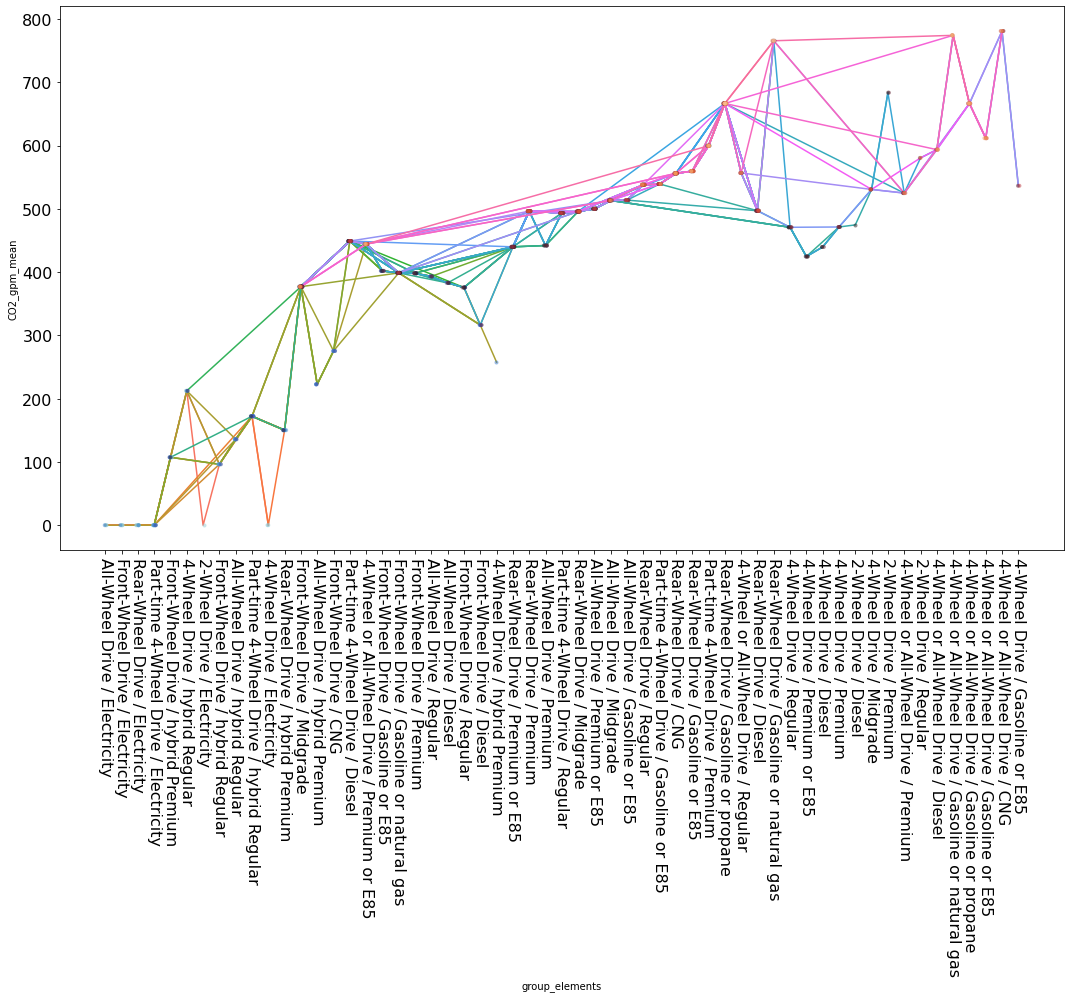

In [ ]:
plt.figure(figsize=(18,10))
sns.stripplot(data=similarity_groups_df, x='group_elements', y='CO2_gpm_mean', hue='similarity_means', palette='icefire', jitter=True, alpha=0.5, s=4)
sns.lineplot( data=similarity_groups_df, hue='similarty_group', y='CO2_gpm_mean', x='group_elements')

plt.legend([],[], frameon=False)
plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

plt.savefig(results_path +'Similarity_groups_rev_03')

#### 3.4.4 Outcomes of Tukey membership visualisations

 

1.   From all the visualisations, we can see that each drive-fuel combination is connected to multiple similaryity groups.
2.   The multiplicity of membership suggests that more work needs to be done to pull apart the data (discussed below)

 



## 3.5 Next Steps - MANOVA

At this point in the analysis, you have a choice,



*   continue perfroming two-way ANOVA analysis, seeing to develop better linear fit useing only two catagorical features
*   or continue to build a model involving more factors.

The second option is refered to as a Many-way ANOVA (MANOVA), or just an ANVOA. The idea being that the output variable is now built from multiple catagorical inputs. These keep in mind that for each additional catagorical factor you gain interaction terms subject to the binomial factor condition given at the begining of section 3.4.

For example a 3 factor model would look like:

$
\mu _{{ijk}}=\mu +\alpha _{i}+\beta _{j}+\zeta_{k}+\gamma _{{ij}}+\eta_{{ik}}+\theta_{{jk}}+κ_{{ijk}}
$

While we could continue to persue this idea further, what should be clear is that makeing models with increasing numbers fo facotrs becomes exponetionally complex with larger and larger numbers of terms which need to be examined and considered.

Due to this we see the need for a different set of tools for working with high dimensional data. These tools will be brought in next week as we begin our exploration of machine learning approaches to high dimensional data.


#3.6 Actions for ANOVA

#### 3.6.0.6  Action Construct a similarty dataframe, looking at pairwise terms which were identified in your two way ANOVA and Tukey analysis.

Use the code which was outlined in section 3.3

In [72]:
tukey_results=pd.read_hdf(results_path+'my_tukey_results')
tukey_results.dtypes

group1       object
group2       object
meandiff    float64
p-adj       float64
lower       float64
upper       float64
reject         bool
dtype: object

In [73]:
tukey_accept_h0= tukey_results.loc[tukey_results.reject == False]

len(tukey_accept_h0)

30

In [74]:
tukey_accept_h0.head(5)

group1                       group2  meandiff   p-adj   lower  \
14  Diesel / 1975-1985          Premium / 2015-2025   -1.0028  0.2314 -2.1844   
18  Diesel / 1975-1985          Regular / 2005-2015   -0.7408  0.7536 -1.9135   
28  Diesel / 1985-1995  Gasoline or E85 / 2015-2025    0.6200  0.9000 -0.8785   
29  Diesel / 1985-1995          Premium / 1975-1985    0.4712  0.9000 -1.6174   
31  Diesel / 1985-1995          Premium / 1995-2005   -0.4770  0.9000 -1.5113   

     upper  reject  
14  0.1788   False  
18  0.4319   False  
28  2.1185   False  
29  2.5599   False  
31  0.5573   False

In [75]:
tukey_groups = tukey_accept_h0.groupby(by='group1')['group2']
tukey_groups

Rerun some code from part 2 to get my data subet of Fuel Type and Year Cat. 

In [81]:
# load dataset
simple_mpg_select=pd.read_excel(results_path + 'simple_mpg_select.xlsx')

In [84]:
simple_mpg_select['interaction'] = simple_mpg_select.fuelType.astype(str) + " / " + simple_mpg_select.year_cat.astype(str)

In [91]:
interaction_groups=mpg_groups=(simple_mpg_select.groupby(['interaction'], observed = True)
                            .average_mpg08
                            .agg(count ='count', mean ='mean', median = 'median', standerd_dev='std', skew ='skew' )
                            .reset_index()
                            .copy())

means_order=(interaction_groups.sort_values('mean',ascending=True))
                                  
median_order =interaction_groups.sort_values('median',ascending=True)

In [69]:
similarity_groups=[]
for group in tukey_groups.groups:
  similarity_groups.append(list(tukey_groups.get_group(group)))

In [98]:
#step 0
dfs=[]
for i,group in enumerate(tukey_groups.groups,0):
  #step 1
  similarity_groups[i].append(group)
  #step 2
  _df=pd.DataFrame(similarity_groups[i], columns=['group_elements'])
  _df["group_elements"] = similarity_groups[i]
  #step 3
  _df["similarity_group"] = _df.tail(1)['group_elements'].values[0]
  #step 4
  _means= interaction_groups[interaction_groups['interaction'].isin(np.unique((_df.group_elements.values)))][['interaction','mean']]
  _df= _df.merge(_means, how="inner", left_on="group_elements", right_on="interaction")
  #step 5
  _df=_df.sort_values('mean',ascending=True)
  _df['mean']=_df['mean'].round(2)
  #step 6
  _df['similarity_means']= _df['mean'].mean()
  _df['similarity_means']=_df['similarity_means'].round(2)
  #step 7
  dfs.append(_df)
  #step 8
similarity_groups_df=pd.concat(dfs,ignore_index=True)
#step 9
similarity_groups_df.rename(columns={'mean':'total_mpg_mean'},inplace=True)
#step 10
similarity_groups_df.sort_values('similarity_means',ascending=True, inplace=True,ignore_index=True)

similarity_groups_df


group_elements             similarity_group  \
0   Gasoline or E85 / 1995-2005  Gasoline or E85 / 1995-2005   
1   Gasoline or E85 / 1995-2005  Gasoline or E85 / 1995-2005   
2   Gasoline or E85 / 1995-2005  Gasoline or E85 / 1995-2005   
3   Gasoline or E85 / 1995-2005  Gasoline or E85 / 1995-2005   
4   Gasoline or E85 / 1995-2005  Gasoline or E85 / 1995-2005   
..                          ...                          ...   
85           Diesel / 1995-2005           Diesel / 1995-2005   
86           Diesel / 1995-2005           Diesel / 1995-2005   
87           Diesel / 1995-2005           Diesel / 1995-2005   
88           Diesel / 1995-2005           Diesel / 1995-2005   
89           Diesel / 1995-2005           Diesel / 1995-2005   

                    interaction  total_mpg_mean  similarity_means  
0   Gasoline or E85 / 1995-2005           17.44             17.72  
1   Gasoline or E85 / 1995-2005           17.44             17.72  
2   Gasoline or E85 / 1995-2005           17.44             17.72  
3   Gasoline or E85 / 1995-2005           17.44             17.72  
4   Gasoline or E85 / 1995-2005           17.44             17.72  
..                          ...             ...               ...  
85           Diesel / 1995-2005           30.75             30.54  
86           Diesel / 1995-2005           30.75             30.54  
87           Diesel / 1995-2005           30.75             30.54  
88           Diesel / 1995-2005           30.75             30.54  
89           Diesel / 1995-2005           30.75             30.54  

[90 rows x 5 columns]

#### 3.6.2 Action: Use some of the visualisation ideas above, or explore the Seaborn gallery to gain ideas on how to demonstre the connectivity between data sets.

Share you results in the [Moodle Forum](https://moodle.gla.ac.uk/mod/forum/view.php?id=2877349)

Comparing these plots to the ones from part 2 shows that the similarity groups included here tend to have low mpg. We can also see that no pairs include electric vehicles which have a higher MPG (see plot from part 5_2). 



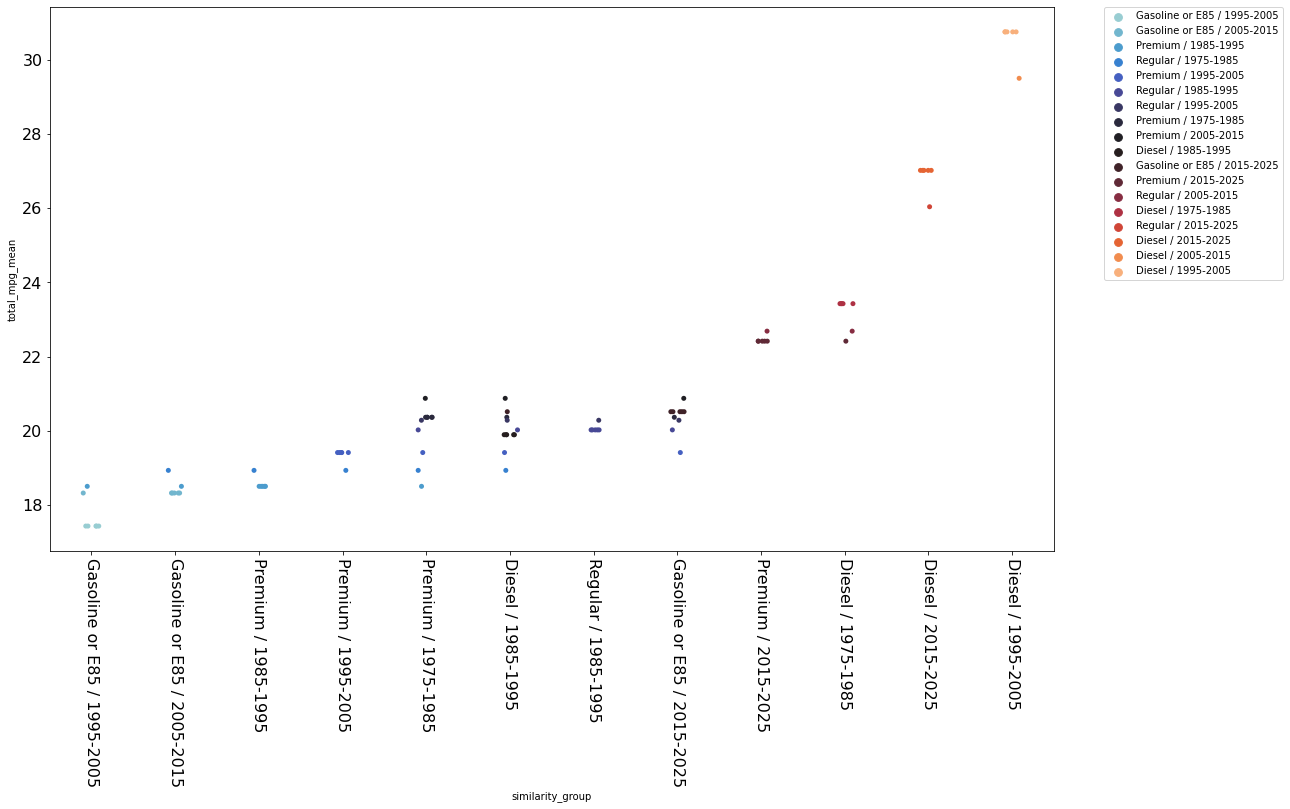

In [101]:
plt.figure(figsize=(18,10))
sns.stripplot(data=similarity_groups_df, x='similarity_group', y='total_mpg_mean', hue='group_elements',
              palette='icefire', jitter=True)

#note control of the legend to force it outside the bounding box of the data region.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

This one is not very informative because there are few pairings and it removes data points from similarity groups that do not have similar means compared to another similarity group. 

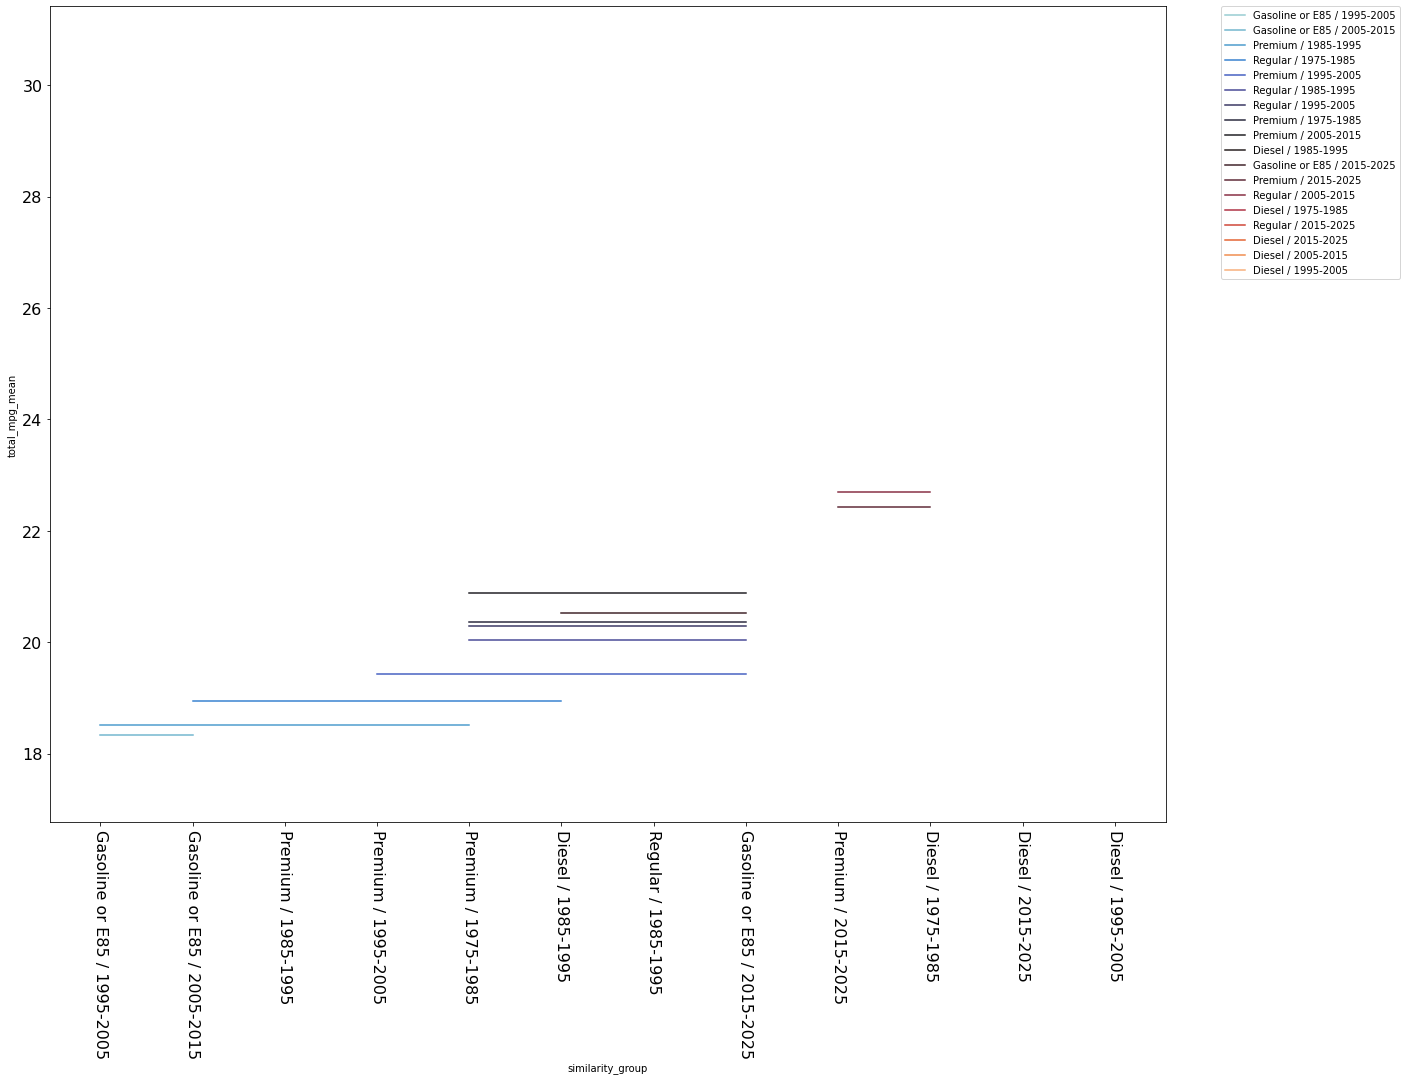

In [103]:
plt.figure(figsize=(20,15))

sns.lineplot( data=similarity_groups_df, x='similarity_group', y='total_mpg_mean', hue='group_elements', palette='icefire')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

The below plot nicely shows what I've described above. 


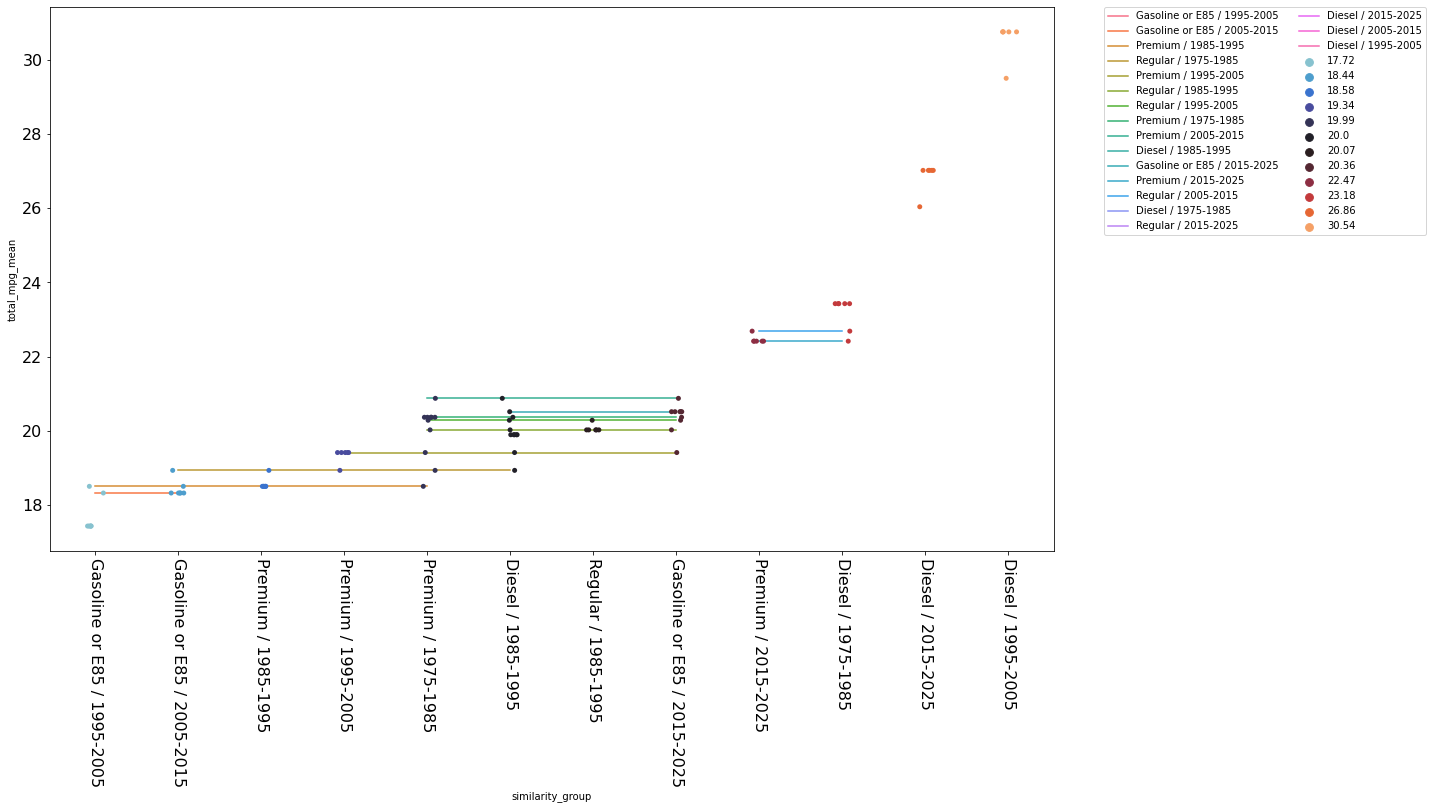

In [104]:
plt.figure(figsize=(18,10))
sns.stripplot(data=similarity_groups_df, x='similarity_group', y='total_mpg_mean', hue='similarity_means', palette='icefire', jitter=True)
sns.lineplot( data=similarity_groups_df, x='similarity_group', y='total_mpg_mean', hue='group_elements')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=2)

plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

#plt.savefig(results_path +'Similarity_groups_rev_02')